In [13]:
import logging
import gurobipy as gp

env = gp.Env(empty=True) 
env.setParam("OutputFlag", 0)
env.setParam("LogToConsole", 0)
env.start()

logging.getLogger("gurobipy").setLevel(logging.ERROR)

logging.basicConfig(
    level=logging.INFO, 
    format="%(levelname)s: %(message)s"
)

# Import Model

This framework will be tested on the *P. Tricornutum* diatom model `iLB1027_lipid`. All metabolic models must be located in the `models` directory. Linear problems use the Gurobi solver by default, but any solver supported by COBRA can be used.

In [14]:
from src import MetabolicExperiment

diatom = MetabolicExperiment("iLB1027_lipid.xml", model_name="P. Tricornutum", solver="gurobi")
diatom.model

ERROR: 'R_AAL(fum)_c' is not a valid SBML 'SId'.
ERROR: 'R_sink_Asn-X-Ser_Thr_c' is not a valid SBML 'SId'.


Name,pti
Memory address,7b2df00adf60
Number of metabolites,2172
Number of reactions,4456
Number of genes,1027
Number of groups,0
Objective expression,1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1
Compartments,"Cytoplasm, Extracellular space, Chloroplast, Mitochondrion, Peroxisome, Thylakoid lumen"


After the model has been loaded into `MetabolicExperiment`, it is possible to change it by adding and modifying metabolites, reactions and/or constraints. Do note that doing so will not overwrite the original metabolic model.

Two experiments are defined.

**Nitrogen Analysis:** A flux constraint is added to simulate nitrate inhibition due to ammonium, whose bounds are controled by the `alpha` parameter.

**Carbon Analysis:** A pseudometabolite `CI` parametrizing inorganic carbon is added. The `alpha` parameter controls the maximum amount of CO2 flux that can come from `CI`.

In [15]:
def carbon_analysis(alpha: float, ci_uptake: float):
    # METABOLITES 
    diatom.add_metabolite('ci_e', formula='Ci', name='Inorganic Carbon', compartment='e')

    # REACTIONS
    reactions = {
        "EX_ci_e": {"ci_e": -1.0}, # inorganic carbon uptake
        "CI_CO2_e": {"ci_e": -1.0, "co2_e": 1.0}, # ci to co2 conversion
        "CI_HCO3_e": {"ci_e": -1.0, "hco3_e": 1.0}, # ci to hco3 conversion
    }
    diatom.add_reactions(reactions)

    # BOUND CONSTRAINTS
    bound_constraints = {
        "EX_photon_e": (-100, 0),
        "EX_no3_e": (-2, 0),
        "EX_nh4_e": (0, 0),
        "EX_co2_e": (0, 0),
        "EX_hco3_e": (0, 0),
        "EX_ci_e": (ci_uptake, 0),
    }
    diatom.modify_bounds(bound_constraints)

    # FLUX CONSTRAINTS

    # v_co2 + alpha * v_ci <= 0
    diatom.add_flux_constraint(
        {"CI_CO2_e": 1.0, "EX_ci_e": alpha}, 
        ub=0, 
        name="CI_CO2_coupling",
    )

    # v_hco3 + (1 - alpha) * v_ci <= 0
    diatom.add_flux_constraint(
        {"CI_HCO3_e": 1.0, "EX_ci_e": 1-alpha}, 
        ub=0, 
        name="CI_HCO3_coupling",
    )

    experiment_tag = f"CarbonAnalysis_alpha_{alpha}"
    reaction_tuple = ("EX_ci_e", "DM_biomass_c")
    extra_plot_title = f"alpha: {alpha}"

    return experiment_tag, reaction_tuple, extra_plot_title


def nitrogen_analysis(alpha: float, ni_uptake: float):
    # BOUND CONSTRAINTS
    CO2_UPTAKE = -5
    HCO3_UPTAKE = -20
    bound_constraints = {
        "EX_photon_e": (-100, 0),
        "EX_no3_e": (ni_uptake, 0),
        "EX_nh4_e": (-alpha, 0),
        "EX_co2_e": (CO2_UPTAKE, 0),
        "EX_hco3_e": (HCO3_UPTAKE, 0),
    }
    diatom.modify_bounds(bound_constraints)

    # v_no3 + v_nh4 >= N_UPTAKE
    diatom.add_flux_constraint(
        {"EX_nh4_e": 1.0, "EX_no3_e": 1.0}, 
        lb=ni_uptake,
        name="NO3_NH4_inhibition",
    )

    experiment_tag = f"NitrogenAnalysis_NH4_uptake_{alpha}"
    reaction_tuple = ("EX_no3_e", "DM_biomass_c")
    extra_plot_title = f"NH4_uptake: {alpha}"

    return experiment_tag, reaction_tuple, extra_plot_title

In [16]:
#experiment_tuple = nitrogen_analysis(alpha=0.0, ni_uptake=-2.0)
experiment_tuple = carbon_analysis(alpha=1.0, ci_uptake=-25.0)
experiment_tag, reaction_tuple, extra_plot_title= experiment_tuple

experiment_tuple

('CarbonAnalysis_alpha_1.0', ('EX_ci_e', 'DM_biomass_c'), 'alpha: 1.0')

In [17]:
from cobra.flux_analysis.parsimonious import pfba
pfba(diatom.model)

,fluxes,reduced_costs
ATPS_m,24.946147,-2.000000
IDP_h,0.147100,-2.000000
IDP_m,0.000000,9.333333
THD2_m,0.000000,16.000000
ATAM_c,1.187382,-2.000000
...,...,...
AGPATCOA_LNA_LNA_c,0.000000,-2.000000
CHOPT_LNA_LNA_c,0.000000,254.000000
EX_ci_e,-8.599392,2.000000
CI_CO2_e,8.599392,-2.000000


Once every change to the model has been set, the `set_sampling_instance` method must be run, in order to create all the necessary directories where I/O interactions will take place. This will create a hash identifier to uniquely characterize the experiment registered.

In [18]:
diatom.set_sampling_instance(
    experiment_tag=experiment_tag,
    reaction_tuple=reaction_tuple,
    use_pfba=False,
    save_files=True,
    load_files=True,
)

INFO: Maximize
1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1

INFO: Generated hash 'CarbonAnalysis_alpha_1.0_#dde82f0852606eca' for current sampling metadata:
model_filename: iLB1027_lipid.xml
model_hash: 155cc3eaf6eb7fe6105855961f4db75bfc66cf72e1b3ac04e205b9dda9121587
reaction_tuple: ('EX_ci_e', 'DM_biomass_c')
metabolites: [{'metabolite_id': 'ci_e', 'formula': 'Ci', 'name': 'Inorganic Carbon', 'compartment': 'e'}]
reactions: [{'EX_ci_e': {'ci_e': -1.0}, 'CI_CO2_e': {'ci_e': -1.0, 'co2_e': 1.0}, 'CI_HCO3_e': {'ci_e': -1.0, 'hco3_e': 1.0}}]
bound_constraints: {'EX_ci_e': [-25.0, 0], 'EX_co2_e': [0, 0], 'EX_hco3_e': [0, 0], 'EX_nh4_e': [0, 0], 'EX_no3_e': [-2, 0], 'EX_photon_e': [-100, 0]}
flux_constraints: [{'expression': {'CI_CO2_e': 1.0, 'EX_ci_e': 1.0}, 'ub': 0, 'name': 'CI_CO2_coupling'}, {'expression': {'CI_HCO3_e': 1.0, 'EX_ci_e': 0.0}, 'ub': 0, 'name': 'CI_HCO3_coupling'}]
use_pfba: False
pfba_fraction_of_optimum: 1.0

All data generated during analysis will be stored at loc

## Polytope Sampling



After the experiment instance has been set, the feasible space can be computed. 

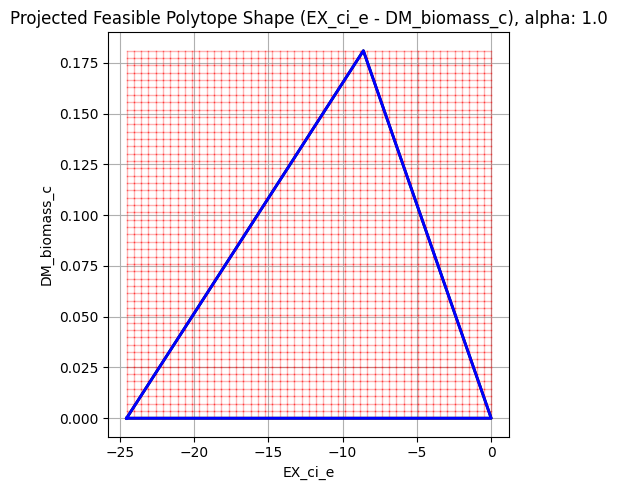

INFO: Running qualitative fva over grid feasible points...
Setting reactions for analysis...

INFO: Number of reactions set for analysis: 4048
INFO: Analyzing point feasibility....
100%|██████████| 1424/1424 [00:00<00:00, 4461.27it/s]
INFO: Done!



In [19]:
def polytope_pipeline(n_partitions: int, **kwargs):
    """Pipeline used to sample the feasible polytope projection for the given reaction tuple."""
    diatom.projection.project_polytope_2d()
    diatom.grid.sample_polytope(n_partitions)
    diatom.plot.polytope_shape(**kwargs) # optional
    diatom.analyze.qualitative_analysis(only_load=False)


polytope_pipeline(n_partitions=50, extra_title=extra_plot_title)

## Getting the Clusters

The number of clusters can be set arbitrarely. However, in this example the number will be determined by computing
how well that amount of clusters (and the resulting qualitative profiles) represent the qualitative states of all reactions. 

INFO: Clustering grid points ...
INFO: Done! Obtained 5 from hierarchical clustering.
INFO: Percentage of reactions represented correctly at 5 clusters: 0.8778311599176389
INFO: Clustering grid points ...
INFO: Done! Obtained 6 from hierarchical clustering.
INFO: Percentage of reactions represented correctly at 6 clusters: 0.9890185312285518
INFO: Clustering grid points ...
INFO: Done! Obtained 7 from hierarchical clustering.
INFO: Percentage of reactions represented correctly at 7 clusters: 0.9876458476321208
INFO: Clustering grid points ...
INFO: Done! Obtained 8 from hierarchical clustering.
INFO: Percentage of reactions represented correctly at 8 clusters: 0.9876458476321208
INFO: Clustering grid points ...
INFO: Done! Obtained 9 from hierarchical clustering.
INFO: Percentage of reactions represented correctly at 9 clusters: 0.9876458476321208
INFO: Clustering grid points ...
INFO: Done! Obtained 9 from hierarchical clustering.
INFO: Percentage of reactions represented correctly at

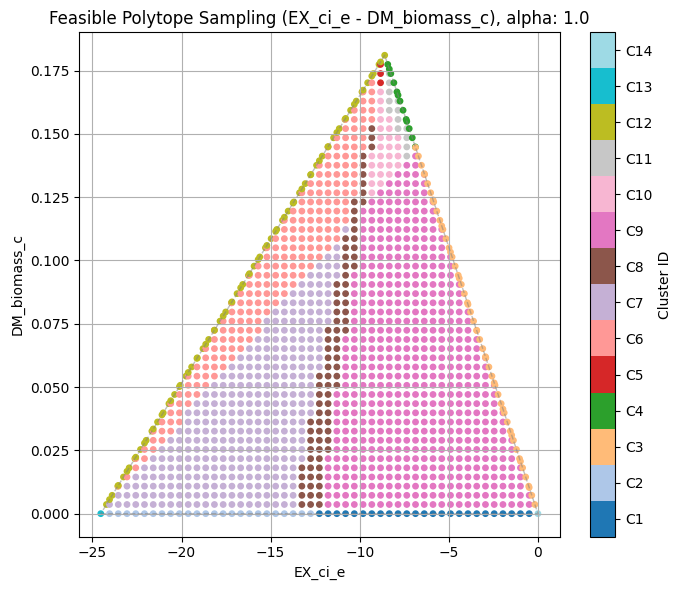

In [20]:
THRESHOLD = 0.95


def find_n_clusters_by_threshold(
    threshold: float, score_threshold: float = 0.99, initial_k: int = 5, final_k: int = 20, selected_reactions: list[str] | None = None,
) -> None:
    """Gets the minimum number of clusters required to represent reactions qualitatively.

    This algorithm iteratively increases the number of clusters used to partition the sampled feasible polytope, 
    and measures how well the representative qualitative profiles obtained from the clusters matches each reaction 
    actual qualitative state. The search stops once the fraction of correctly represented reactions exceeds a target score.

    During execution, filesystem I/O is disabled to avoid overwritting stored results with intermediate clusterings.

    Parameters
    ----------
    threshold : float
        Minimum fraction of grid points within a cluster required for a reaction to be assigned a consistent qualitative state.

    score_threshold : float, default=0.99
        Target fraction of reactions that must be correctly represented in order to stop increasing the number of clusters.

    initial_k : int, default=4
        Initial number of clusters to test.

    final_k : int, default=20
        Maximum number of clusters to test. The search stops earlier if `score_threshold` is reached.

    selected_reactions : list[str] or None, default=None
        Optional subset of reactions to consider when computing qualitative profiles and representation scores. 
        If None, all reactions are used during FVA analysis will be considered.
    """
    save_files = diatom.io.save_files
    load_files = diatom.io.load_files
    diatom.io.save_files = False
    diatom.io.load_files = False

    def get_score(k: int):
        diatom.clustering.set_clusters(n_clusters=k, linkage_method='complete')
        diatom.clustering.get_cluster_qualitative_profiles(
            threshold=threshold, 
            changing=True, 
            selected_reactions=selected_reactions, 
            overwrite=False,
        )
        success_score, _ = diatom.clustering.n_clusters_score(threshold=threshold)
        return success_score

    for k in range(initial_k, final_k):
        score = get_score(k)
        logging.info(f"Percentage of reactions represented correctly at {k} clusters: {score}")
        if score >= score_threshold:
            break
    
    diatom.io.save_files = save_files
    diatom.io.load_files = load_files

    
find_n_clusters_by_threshold(threshold=THRESHOLD)

diatom.plot.sampled_polytope(show_boundary=True, extra_title=extra_plot_title)

## Selecting Reactions for In-Depth Analysis

In [21]:
scores_df, rank_df, reaction_list = diatom.clustering.reaction_scores(top_T=20)
rank_df

INFO: Number of reactions selected: 31



,rf_importance,mca_score,intra_inter,mutual_information,entropy,coefficient_of_variation,votes
EX_h_e,4.0,1.0,1.0,2.0,1.0,84.0,5
DM_for_c,5.0,5.0,2.0,1.0,2.0,23.0,5
MTOBTA_c,359.0,12.0,31.0,14.0,15.0,17.0,4
PIt_m,3.0,324.0,34.0,10.0,12.0,3838.0,3
ATP2t_m,2.0,1456.5,130.5,11.5,13.5,3843.0,3
ATPS_m,6.0,1454.0,509.0,13.0,10.0,3803.0,3
ATPt_m,1.0,1456.5,130.5,11.5,13.5,3833.0,3
ALANA1t_m,8.0,1451.0,255.0,7.0,7.0,3469.0,3
GCS_m,9.0,957.0,32.0,3.0,3.0,910.0,3
CO2t_m,10.0,318.0,41.0,4.0,4.0,3814.0,3


In [22]:
EXTRA_REACTIONS = [
    "NO3t_e",
    "PHOt_e",
    "CA_h",
    "CA_m",
]

if "CO2t_e" in diatom.non_blocked:
    EXTRA_REACTIONS.append("CO2t_e")

if "NAHCO3CLt_e" in diatom.non_blocked:
    EXTRA_REACTIONS.append("NAHCO3CLt_e")

if "NH4t_e" in diatom.non_blocked:
    EXTRA_REACTIONS.append("NH4t_e")  

all_reactions = reaction_list + EXTRA_REACTIONS


print(f"Number of reactions considered: {len(all_reactions)}")
reaction_info = diatom.clustering.get_reactions_dataframe(all_reactions)
reaction_info

Number of reactions considered: 36


,Reaction ID,Full Name,Reaction,Metabolite List
0,EX_h_e,H+ exchange,h_e <=>,{H+}
1,DM_for_c,Demand for_c,for_c -->,{Formate}
2,MTOBTA_c,4-Methylthio-2-oxobutanoate transaminase,2kmb_c + glu__L_c <=> akg_c + met__L_c,"{2-Oxoglutarate, 4-Methylthio-2-oxobutanoic ac..."
3,PIt_m,"Phosphate transport, mitochondria",h_c + pi_c <=> h_m + pi_m,"{H+, Phosphate}"
4,ATP2t_m,"ADP/ATP antiport, mitochondria, step 2",atp_m --> atp_c,{ATP}
5,ATPS_m,F0F1-ATP synthase Complex V,adp_m + 4.0 h_c + pi_m <=> atp_m + h2o_m + 3.0...,"{H2O, H+, ADP, Phosphate, ATP}"
6,ATPt_m,"ADP/ATP antiport, mitochondria step 1",adp_c --> adp_m,{ADP}
7,ALANA1t_m,"Alanine:Na+ symporter, mitochondrial",ala__L_m + na1_m <=> ala__L_c + na1_c,"{Sodium cation, L-Alanine}"
8,GCS_m,Glycine cleavage system--Glycine synthase,co2_m + mlthf_m + nadh_m + nh4_m <=> gly_m + n...,"{NH4+, 5,6,7,8-Tetrahydrofolate, NADH, CO2, 5,..."
9,CO2t_m,"CO2 diffusion, mitochondrial",co2_c <=> co2_m,{CO2}


## Getting Qualitative Profiles and Metrics

Before running the rest of the pipeline, metrics specific to this experiment are defined, in order to monitor reactions of interest.

In [23]:
CARBON_UPTAKE = []
if "CO2t_e" in diatom.non_blocked:
    CARBON_UPTAKE.append("CO2t_e")
if "NAHCO3CLt_e" in diatom.non_blocked:
    CARBON_UPTAKE.append("NAHCO3CLt_e")

NITROGEN_UPTAKE = ["NO3t_e"]
if "NH4t_e" in diatom.non_blocked:
    NITROGEN_UPTAKE.append("NH4t_e")  

ASSIMILATED_CARBON = ["biomass_mem_lipids_c", "biomass_carb_c", "biomass_TAG_c"]
ASSIMILATED_NITROGEN = ["biomass_pro_c", "biomass_DNA_c","biomass_RNA_c"]


# Relative Rubisco carboxylation vs oxygenation activity within a cluster.
diatom.clustering.set_ratio_metric(
    metric_name="rubisco_carboxylation_fraction", 
    numerator="RUBISC_h", 
    denominator="RUBISO_h", 
    den_func=lambda x,y: x+y,
)

# Normalized difference between photon uptake and Rubisco flux.
diatom.clustering.set_ratio_metric(
    metric_name="photons_per_rubisc_difference_ratio", 
    numerator="PHOt_e",
    denominator="RUBISC_h", 
    num_func=lambda x,y: x-y, 
    den_func=lambda x,y: x+y,
)

# Photon uptake to Rubisco flux ratio.
diatom.clustering.set_ratio_metric(
    metric_name="photons_per_rubisc_simple_ratio",
    numerator="PHOt_e",
    denominator="RUBISC_h", 
)

# Normalized difference between nitrate uptake and Rubisco flux.
diatom.clustering.set_ratio_metric(
    metric_name="no3_per_rubisc_difference_ratio", 
    numerator="NO3t_e",
    denominator="RUBISC_h", 
    num_func=lambda x,y: x-y, 
    den_func=lambda x,y: x+y,
)

# Nitrate uptake to Rubisco flux ratio.
diatom.clustering.set_ratio_metric(
    metric_name="no3_per_rubisc_simple_ratio",
    numerator="NO3t_e",
    denominator="RUBISC_h",
)

# Normalized difference between CO2 uptake and Rubisco flux.
diatom.clustering.set_ratio_metric(
    metric_name="co2_per_rubisc_difference_ratio",
    numerator="CO2t_h",
    denominator="RUBISC_h",
    num_func=lambda x, y: x - y,
    den_func=lambda x, y: x + y,
)

# CO2 uptake to Rubisco flux ratio.
diatom.clustering.set_ratio_metric(
    numerator="CO2t_h",
    denominator="RUBISC_h",
    metric_name="co2_per_rubisc_simple_ratio",
)

# Relative nitrate uptake compared to total nitrogen biomass synthesis.
diatom.clustering.set_ratio_metric(
    numerator=ASSIMILATED_NITROGEN,
    denominator=NITROGEN_UPTAKE,
    metric_name="nitrogen_assimilation_ratio",
    den_func=lambda x, y: x + y,
)

# Relative carbon uptake compared to total carbon biomass synthesis.
diatom.clustering.set_ratio_metric(
    numerator=ASSIMILATED_CARBON,
    denominator=CARBON_UPTAKE,
    metric_name="carbon_assimilation_ratio",
    den_func=lambda x, y: x + y,
)


diatom.clustering.set_ratio_metric(
    numerator=CARBON_UPTAKE,
    denominator=NITROGEN_UPTAKE,
    metric_name="C_to_N_uptake_ratio",
)


diatom.clustering.set_ratio_metric(
    numerator=ASSIMILATED_CARBON,
    denominator=ASSIMILATED_NITROGEN,
    metric_name="C_to_N_biomass_ratio",
)


diatom.clustering.show_all_metrics()

Reaction Metrics:
['minimum', 'maximum', 'mean_range', 'mean_midpoint', 'median_range', 'median_midpoint', 'mean_abs_flux', 'std_range', 'frac_variable', 'frac_fixed', 'frac_bidirectional']

Global Metrics:
['mean_range_all_reactions', 'median_range_all_reactions', 'std_range_all_reactions', 'blocked_fraction_all_reactions', 'rubisco_carboxylation_fraction', 'photons_per_rubisc_difference_ratio', 'photons_per_rubisc_simple_ratio', 'no3_per_rubisc_difference_ratio', 'no3_per_rubisc_simple_ratio', 'co2_per_rubisc_difference_ratio', 'co2_per_rubisc_simple_ratio', 'nitrogen_assimilation_ratio', 'carbon_assimilation_ratio', 'C_to_N_uptake_ratio', 'C_to_N_biomass_ratio', 'rubisco_carboxylation_fraction', 'photons_per_rubisc_difference_ratio', 'photons_per_rubisc_simple_ratio', 'no3_per_rubisc_difference_ratio', 'no3_per_rubisc_simple_ratio', 'co2_per_rubisc_difference_ratio', 'co2_per_rubisc_simple_ratio', 'nitrogen_assimilation_ratio', 'carbon_assimilation_ratio', 'C_to_N_uptake_ratio', 'C_

In [24]:
import pandas as pd

def clustering_pipeline(
    reaction_list: list[str], threshold: float, changing: bool = False, overwrite: bool = False, extra_dataframes: dict[str, pd.DataFrame] | None = None,
) -> None:
    """Computes qualitatives profiles for each cluster, alongside global and reaction-level metrics
    in order to retrieve quantitative data. The number of clusters must be set beforehand using
    `MetabolicExperiment.clustering.set_clusters()`.
    """
    print("Qualitative Profiles "+"="*80+"\n")
    qualitative_profiles = diatom.clustering.get_cluster_qualitative_profiles(
        threshold=threshold, 
        changing=changing, 
        selected_reactions=reaction_list, 
        overwrite=overwrite,
    )
    display(qualitative_profiles)

    print("Per Reaction Metrics "+"="*80+"\n")
    metrics_per_reaction = diatom.clustering.get_cluster_metrics_per_reaction(reaction_list, overwrite=overwrite)
    display(metrics_per_reaction)

    print("Global Metrics "+"="*80+"\n")
    global_metrics = diatom.clustering.get_cluster_global_metrics(reaction_list, overwrite=overwrite)
    display(global_metrics)

    dataframe_colection = {
        "qualitative profiles": qualitative_profiles, 
        "per reaction metrics": metrics_per_reaction, 
        "global metrics": global_metrics,
    }
    if extra_dataframes is not None:
        for dataframe_name, dataframe in extra_dataframes.items():
            dataframe_colection[dataframe_name] = dataframe

    diatom.io.merge_to_excel(dataframe_colection)


clustering_pipeline(
    all_reactions, 
    threshold=THRESHOLD, 
    overwrite=True, 
    extra_dataframes={
        "reaction information": reaction_info,
        "reaction ranking": rank_df.reset_index(names="reaction id"),
        "reaction scores": scores_df.reset_index(names="reaction id"),
    }
)

Qualitative Profiles ================================================================================



,reaction id,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14
0,EX_h_e,-+,++,-,-,--,++,++,NaN,NaN,-+,--,+,+,0
1,DM_for_c,0+,++,0,0,++,++,++,++,0+,0+,0+,+,+,0
2,MTOBTA_c,-0,-0,+,+,-+,-+,-+,-+,-+,-+,-+,+,0,0
3,PIt_m,-+,-+,-+,++,++,++,-+,NaN,-+,++,++,++,0+,-+
4,ATP2t_m,0+,0+,0+,++,++,++,0+,NaN,0+,++,++,++,0+,0+
5,ATPS_m,NaN,++,-+,++,++,++,++,++,NaN,++,++,++,++,-+
6,ATPt_m,0+,0+,0+,++,++,++,0+,NaN,0+,++,++,++,0+,0+
7,ALANA1t_m,-+,NaN,-+,NaN,--,--,--,-+,-+,-+,NaN,--,--,-+
8,GCS_m,-+,--,-+,-+,--,--,--,--,-+,-+,-+,-,-,-+
9,CO2t_m,-+,--,-+,-+,NaN,--,--,NaN,-+,-+,-+,--,--,-0


Per Reaction Metrics ================================================================================



,reaction_id,cluster,metric,value
0,EX_h_e,1,minimum,-3.075797
1,EX_h_e,1,maximum,12.265823
2,EX_h_e,1,mean_range,8.025615
3,EX_h_e,1,mean_midpoint,2.365420
4,EX_h_e,1,median_range,9.061519
...,...,...,...,...
5539,CO2t_e,14,mean_abs_flux,0.000000
5540,CO2t_e,14,std_range,0.000000
5541,CO2t_e,14,frac_variable,0.000000
5542,CO2t_e,14,frac_fixed,1.000000


Global Metrics ================================================================================



,cluster,metric,value
0,1,mean_range_all_reactions,131.351377
1,1,median_range_all_reactions,133.762335
2,1,std_range_all_reactions,237.525316
3,1,blocked_fraction_all_reactions,0.037549
4,1,rubisco_carboxylation_fraction,0.979166
...,...,...,...
359,14,co2_per_rubisc_simple_ratio,3.845948
360,14,nitrogen_assimilation_ratio,0.000000
361,14,carbon_assimilation_ratio,0.000000
362,14,C_to_N_uptake_ratio,0.000000
